In [1]:
from yad2k.model import TinyYOLOv2
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body
import cv2
import random
from sklearn.cross_validation import train_test_split
from keras import backend as K

Using TensorFlow backend.
/home/vishwesh/anaconda3/envs/tensorflow/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [14]:
df_training = pd.read_csv("./training.csv")
df_test = pd.read_csv("./test.csv")

In [15]:
df_training.head()

,image_name,x1,x2,y1,y2
0,JPEG_20160706_121146_1000145715002.png,115,495,143,325
1,JPEG_20161119_174038_1000690577600.png,23,457,61,409
2,147444927651111470309333776-Roadster-Men-Casua...,37,601,13,470
3,147772332675720161028_161611.png,27,602,162,385
4,1473315333651DeeplearnS11638.png,60,586,174,325


In [16]:
df_test.head()

,image_name,x1,x2,y1,y2
0,1474723840903DSC08089.png,NaN,NaN,NaN,NaN
1,1473231475010DeeplearnS11276.png,NaN,NaN,NaN,NaN
2,JPEG_20161205_135307_1000155917326.png,NaN,NaN,NaN,NaN
3,JPEG_20160711_123440_1000518778437.png,NaN,NaN,NaN,NaN
4,JPEG_20160803_115329_100034020722.png,NaN,NaN,NaN,NaN


In [17]:
#Preprocessing step
df_training['image_name'] = './images/' + df_training['image_name'].astype(str) 
df_test['image_name'] = './images/' + df_test['image_name'].astype(str) 
df_training['bx'] = (df_training.x1 + df_training.x2)/2
df_training['by'] = (df_training.y1 + df_training.y2)/2
df_training['bh'] = abs(df_training.y1 - df_training.y2)
df_training['bw'] = abs(df_training.x1 - df_training.x2)
df_training = df_training.drop(["x1","x2","y1","y2"],axis=1)

#Normalizes the bounding box coordinates
#Resizing the images to have 480*480 dimensions, hence changing the box coordinates
df_training['bx'] = df_training['bx']/640
df_training['bw'] = df_training['bw']/640
df_training['by'] = df_training['by']/480
df_training['bh'] = df_training['bh']/480
df_training.head()

,image_name,bx,by,bh,bw
0,./images/JPEG_20160706_121146_1000145715002.png,0.476562,0.487500,0.379167,0.593750
1,./images/JPEG_20161119_174038_1000690577600.png,0.375000,0.489583,0.725000,0.678125
2,./images/147444927651111470309333776-Roadster-...,0.498437,0.503125,0.952083,0.881250
3,./images/147772332675720161028_161611.png,0.491406,0.569792,0.464583,0.898438
4,./images/1473315333651DeeplearnS11638.png,0.504687,0.519792,0.314583,0.821875


./images/147185868090020160818_111244.png


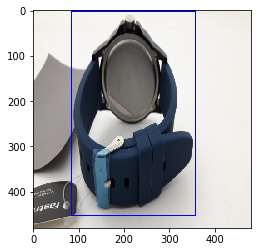

In [18]:
Rand = random.randint(0,len(df_training))
print(df_training.image_name.iloc[Rand])
(img_path,bx,by,h,w) = df_training.iloc[Rand]
[bx,by,h,w] = [bx*480,by*480,h*480,w*480]
img = cv2.imread(img_path) 
img = cv2.resize(img,(480,480))
cv2.rectangle(img, (int(bx-w/2), int(by-h/2)), (int(bx+w/2), int(by+h/2)), (255,0,0), 2)
temp = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(temp)
plt.show()

In [25]:
#Dividing data into cross-val, train set
#2000 data for cross-val and 12000 for train

df_training = df_training.sample(frac=1).reset_index(drop=True)
df_train = df_training.iloc[:12000,:]
df_test =  df_training.iloc[12000::,:]


In [ ]:
# Data Pipeline
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [8]:
model = TinyYOLOv2(480)
model.m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 480, 480, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 480, 480, 16)      432       
_________________________________________________________________
batch_normalization_1 (Batch (None, 480, 480, 16)      64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 480, 480, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 240, 240, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 240, 240, 32)      4608      
_________________________________________________________________
batch_normalization_2 (Batch (None, 240, 240, 32)      128       
__________

In [23]:
#Just Experimenting to see if it gives sensible results
img_path = df_training.iloc[:2].image_name
img_list = []
for i in range(2):
    img = cv2.imread(img_path[i])
    img = img/255.
    img = cv2.resize(img,(480,480))
    img_list.append(img)
yolo_out = yolo_head(model.m.output,[[1.08, 1.19]])
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    box_confidence, box_xy, box_wh = sess.run(yolo_out,feed_dict={model.m.input:img_list})